Tic Tac Toe

In [1]:
import numpy as np
import nnet as nn
import cPickle
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def getAdjacent(coordinate2D):
    
    """Gets adjacent locations for a given location"""
    
    return np.add(coordinate2D, [[0,1],[1,0],[1,1],[-1,-1],[1,-1],[0,-1],[-1,1],[-1,0]])

In [3]:
class fixedPlayer(object):
    
    """A fixed evaluator program"""
    
    def __init__(self, symbol):
        
        """Player either places a X or O depending on the initialized option"""
        
        self.symbol = symbol
        
    def chooseMove(self, boardStatus):
        
        """The player chooses its move based on what the board looks like.
        First, it gets all possible blank spaces"""
        
        # Board status is an array with 3x3 size
        
        # Choosing locations from available positions depends on the following rules:
        # 1. If next choice means endgame, game will choose it unconditionally
        # 2. If the next move of opponent leads to endgame, the player chooses against it unconditionally
        # 3. If already symbol is present, it will randomly choose a nearby location in same row, 
        # column or diagonal
        # 4. Failing the above 4 it reverts to a random choice (Usually in the beginning of a game)
        
        # Check if player has not placed a pawn and get opponent status
        # emptyLocations = [[i,j] for i in range(3) for j in range(3) if boardStatus[i][j] == '']
        # playerFilledLocations = [[i,j] for i in range(3) for j in range(3) if boardStatus[i][j] == self.symbol]
        symbolArray = ["X","O"]
        opponentSymbol = symbolArray[1 - symbolArray.index(self.symbol)]
        
        possibleLocations = []
        riskLocations = []
        
        # Check if rows have any case completion if board is not empty
        if(len(boardStatus != '') > 0):
            for i in range(3):
                boardRow = boardStatus[i,:]
                boardCol = boardStatus[:,i]
                
                # If row has 2 of your symbols and one empty slot
                if((sum(boardRow == self.symbol) == 2) & (sum(boardRow == '') == 1)):
                    return([i,np.where(boardRow == '')[0][0]])
                elif((sum(boardRow == opponentSymbol) == 2) & (sum(boardRow == '') == 1)):
                    riskLocations.append([i,np.where(boardRow == '')[0][0]])
                elif((sum(boardRow == self.symbol) == 1) & (sum(boardRow == '') == 2)):
                    possibleLocations.append([i, np.where(boardRow == '')[0][0]])
                    possibleLocations.append([i, np.where(boardRow == '')[0][1]])
                    
                
                # If columns has 2 of your symbols and one empty slot
                if((sum(boardCol == self.symbol) == 2) & (sum(boardCol == '') == 1)):
                    return([np.where(boardCol == '')[0][0],i])
                elif((sum(boardCol == opponentSymbol) == 2) & (sum(boardCol == '') == 1)):
                    riskLocations.append([np.where(boardCol == '')[0][0],i])
                elif((sum(boardCol == self.symbol) == 1) & (sum(boardCol == '') == 2)):
                    possibleLocations.append([np.where(boardCol == '')[0][0],i])
                    possibleLocations.append([np.where(boardCol == '')[0][1],i])
            
            # Check if the same is happening on diagonals
            boardDiagonal1 = boardStatus.diagonal()
            # If primary diagonal has 2 of your symbols and one empty slot
            if((sum(boardDiagonal1 == self.symbol) == 2) \
               & (sum(boardDiagonal1 == '') == 1)):
                i = np.where(boardDiagonal1 == '')[0][0]
                return([i,i])
            elif((sum(boardDiagonal1 == opponentSymbol) == 2) \
                 & (sum(boardDiagonal1 == '') == 1)):
                i = np.where(boardDiagonal1 == '')[0][0]
                riskLocations.append([i,i])
            elif((sum(boardDiagonal1 == self.symbol) == 1) \
                 & (sum(boardDiagonal1 == '') == 2)):
                i = np.where(boardDiagonal1 == '')[0][0]
                j = np.where(boardDiagonal1 == '')[0][1]
                possibleLocations.append([i,i])
                possibleLocations.append([j,j])
            
            
            # Check if the same is happening on diagonals
            boardDiagonal2 = np.fliplr(boardStatus).diagonal()
            # If primary diagonal has 2 of your symbols and one empty slot
            if((sum(boardDiagonal2 == self.symbol) == 2) \
               & (sum(boardDiagonal2 == '') == 1)):
                i = np.where(boardDiagonal2 == '')[0][0]
                return([i,2-i])
            elif((sum(boardDiagonal2 == opponentSymbol) == 2) \
                 & (sum(boardDiagonal2 == '') == 1)):
                i = np.where(boardDiagonal2 == '')[0][0]
                riskLocations.append([i,2-i])
            elif((sum(boardDiagonal2 == self.symbol) == 1) \
                 & (sum(boardDiagonal2 == '') == 2)):
                i = np.where(boardDiagonal2 == '')[0][0]
                j = np.where(boardDiagonal2 == '')[0][1]
                possibleLocations.append([i,2-i])
                possibleLocations.append([j,2-j])
            
            # After checking for best possible locations, if location is not avaiable,
            # it chooses a random empty slot
            # First update for risk locations
            
            
            if(len(riskLocations) > 0):
                return riskLocations[np.random.choice(range(len(riskLocations)))]
            
            if(len(possibleLocations) > 0):
                return possibleLocations[np.random.choice(range(len(possibleLocations)))]
            else:
                emptyLocations = [[i,j] for i in range(3) for j in range(3) if boardStatus[i][j] == '']
                return emptyLocations[np.random.choice(range(len(emptyLocations)))]
            
        # If board is empty, player chooses random slot
        else:
            allLocations = np.random.choice([[i,j] for i in range(3) for j in range(3)])            
            return allLocations[np.random.choice(range(len(allLocations)))]

In [4]:
class manualPlayer(object):
    
    def __init__(self, symbol):
        self.symbol = symbol
        
    
    # Asks user for an input
    def chooseMove(self, boardStatus):
        
        # Taking user input for playing
        position = raw_input("Enter your choice: ").split(" ")
        position = map(int, position)
        return position

In [5]:
class aiPlayer(object):
    
    """An AI player. Learns to play by playing against opponents"""
    
    def __init__(self, symbol):
            
        symbolArray = ["X","O"]
        
        self.symbol = symbol

        self.opponentSymbol = symbolArray[1 - symbolArray.index(self.symbol)]
        
        # Features to the learning net. This net evaluates the best option available for the :
        # 1. No, of single self symbol rows/columns or diagonals
        # 2. No. of single opponent symbol rows/columns or diagonals
        # 3. No. of double self symbol rows/columns or diagonals
        # 4. No. of double opponent symbol rows/columns or diagonals
        # 5. Blocked opponent wins
        # 6. Blocked self wins
        self.learningNet = nn.neuralNet(weightInit="random",actFun="linear",
                                        layers=[{"type":"linear", "numInputs":6, "layerSize":1},
                                                {"type":"activation"}])
        
        self.value = 0.
        
    def calculateBoardValue(self, boardStatus):
        
        """Returns a feature vector mapping the board status to a real value"""
        
        # No. of single self symbol rows
        rowStatus = np.array([[sum(row == self.symbol),sum(row == self.opponentSymbol),sum(row == "")]
                              for row in boardStatus])
        colStatus = np.array([[sum(row == self.symbol),sum(row == self.opponentSymbol),sum(row == "")] 
                              for row in boardStatus.T])
        diag1 = boardStatus.diagonal()
        diag2 = np.fliplr(boardStatus).diagonal()
        diag1Status = np.array([[sum(diag1 == self.symbol),sum(diag1 == self.opponentSymbol),sum(diag1 == "")]])
        diag2Status = np.array([[sum(diag2 == self.symbol),sum(diag2 == self.opponentSymbol),sum(diag2 == "")]])
        
        allStatus = np.concatenate((rowStatus,colStatus,diag1Status,diag2Status),axis = 0)
        
        # Calculating all variables for the board
        singleSelf =  sum((allStatus[:,0] == 1) & (allStatus[:,2] == 2))/8
        singleOpponent = sum((allStatus[:,1] == 1) & (allStatus[:,2] == 2))/8
        doubleSelf = sum((allStatus[:,0] == 2) & (allStatus[:,2] == 1))/8
        doubleOpponent = sum((allStatus[:,1] == 2) & (allStatus[:,2] == 1))/8
        blockOpponent = sum((allStatus[:,1] == 2) & (allStatus[:,0] == 1))/8
        blockSelf = sum((allStatus[:,0] == 2)  & (allStatus[:,1] == 1))/8
        
        featureValues = np.array([[singleSelf, singleOpponent, 
                                   doubleSelf, doubleOpponent,
                                   blockOpponent, blockSelf]])
        
        # Calculate value from the net
        value = self.learningNet.predict(featureValues)
        return featureValues, value[0][0]
        
    
    def trainTicTac(self, featureVector, value):
        
        """Takes a feature vector and trains the AI"""
        self.learningNet.backProp(numEpochs = 1, batchSize = 1, learnRate = 0.01,
                                  showStep = 1,stepError = 1,
                                  trainInput = featureVector, trainOutput = value,
                                  testInput = featureVector, testOutput = value,
                                  regularize = "none",lambdaReg = 0.01,
                                  beta1 = 0.9, beta2 = 0.999, eps = 1e-8)
        
        
    def chooseMove(self, boardStatus):
        
        # First step is to understand where there are empty positions
        """This is a neural network driven choice"""
        
        boardBackup = np.array([boardStatus[i,j] for i in range(3) for j in range(3)])
        
        # Check for empty slot
        emptyLocations = np.array([[i,j] for i in range(3) for j in range(3) if boardStatus[i,j] == ""])
        
        locationValues = np.zeros(len(emptyLocations))
        
        # Update board with symbol at every possible location 
        for i in range(len(emptyLocations)):
            boardBackup[emptyLocations[i]] = self.symbol
            locationValues[i] = self.calculateBoardValue(boardStatus)[1]
            boardBackup = np.array([boardStatus[i,j] for i in range(3) for j in range(3)])
            
        np.random.seed()
        
        locationValues = locationValues + np.array([np.random.rand() * np.random.choice([1,-1]) * 1e-4 \
                                                    for i in range(len(locationValues))])
        
        bestMove = np.argmax(locationValues)
        self.value = max(locationValues)
        return emptyLocations[bestMove]

In [6]:
class gameBoard(object):
    
    """Game board"""
    
    def __init__(self):
        # Board with all empty positions
        self.boardStatus = np.array(['' for i in range(9)]).reshape(3,3)
        
    def updateStatus(self, position, symbol):
    
        
        # Check if position is already occupied with X or O
        # position is a 2D 
        if(self.boardStatus[position[0]][position[1]] in ["X","O"]):
            # Returns invalid status
            return 0
        else:
            # Update boardstatus
            self.boardStatus[position[0]][position[1]] = symbol
            return 1

In [7]:
class tictactoeGame(object):
    
    """A game AI that starts with 2 plays till game is over"""
    
    def __init__(self, player1, player2):
        self.p1 = player1
        self.p2 = player2
            
        self.board = gameBoard()
        
    def checkWinState(self, symbol):
        
        for i in range(3):
            
            boardRow = self.board.boardStatus[i,:]
            boardCol = self.board.boardStatus[:,i]
            
            if(sum(boardRow == symbol) == 3):
                return 1
            if(sum(boardCol == symbol) == 3):
                return 1
        
        boardDiagonal1 = self.board.boardStatus.diagonal()
        boardDiagonal2 = np.fliplr(self.board.boardStatus).diagonal()
        
        if(sum(boardDiagonal1 == symbol) == 3):
            return 1
        if(sum(boardDiagonal2 == symbol) == 3):
            return 1
        
        if(len([1 for i in range(3) for j in range(3) if self.board.boardStatus[i,j] == '']) == 0):
            return 2
        return 0
        
            
    def playGame(self):

        # Game asks for input from player 1, updates boardStatus and then checks for winstate
        # if not winning, then it proceeds to get input from player 2,
        # updates board and then checks for winstate
        
        # Run till game ends
        endState = 0
        
        while(not endState):
            
            print self.board.boardStatus
            
            # Repeat till user makes valid choice
            validChoice1 = 0
            validChoice2 = 0
            
            while(not validChoice1):
                
                p1Choice = self.p1.chooseMove(self.board.boardStatus)
                validChoice1 = self.board.updateStatus(p1Choice, self.p1.symbol)
                
            endState = self.checkWinState("X")
            
            if(endState == 2):
                print self.board.boardStatus
                return "Match Drawn"
            elif(endState == 1):
                print self.board.boardStatus
                return "Player 1 Has Won"
            
            print self.board.boardStatus
        
            while(not validChoice2):
                
                p2Choice = self.p2.chooseMove(self.board.boardStatus)
                validChoice2 = self.board.updateStatus(p2Choice, self.p2.symbol)
                
            endState = self.checkWinState("O")
            
            if(endState == 2):
                print self.board.boardStatus
                return "Match Drawn"
            elif(endState == 1):
                print self.board.boardStatus
                return "Player 2 Has Won"

In [8]:
class tictactoeTrainer(object):
    
    """Trains an AI to play tic tac toe"""
    
    
    def __init__(self, aiPlayer):
        
        self.aiPlayer = aiPlayer
        
        self.ai = 0
        self.fixed = 0
        self.draw = 0
        
        self.stats = None
        
    def checkWinState(self, symbol, boardStatus):
        
        for i in range(3):
            
            boardRow = boardStatus[i,:]
            boardCol = boardStatus[:,i]
            
            if(sum(boardRow == symbol) == 3):
                return 1
            if(sum(boardCol == symbol) == 3):
                return 1
        
        boardDiagonal1 = boardStatus.diagonal()
        boardDiagonal2 = np.fliplr(boardStatus).diagonal()
        
        if(sum(boardDiagonal1 == symbol) == 3):
            return 1
        if(sum(boardDiagonal2 == symbol) == 3):
            return 1
        
        if(len([1 for i in range(3) for j in range(3) if boardStatus[i,j] == '']) == 0):
            return 2
        return 0
        
    def trainAI(self, numGames, showStat = 100):
        
        self.stats = np.zeros(numGames/showStat * 3).reshape(numGames/showStat,3)
    
        # Runs game for the number of times specified
        symbolArray = ["X","O"]
        
        for game in range(numGames):  
            
            if((game + 1) % showStat == 0):
                
                self.stats[game/showStat] = [self.ai/100., self.draw/100., self.fixed/100.]
                self.ai = 0
                self.fixed = 0
                self.draw = 0
            
            playerType = np.random.choice(symbolArray)
            
            if playerType == "X":
                
                self.aiPlayer.symbol = "X"
                plyr = fixedPlayer(symbol="O")
            
            elif playerType == "O":
                
                plyr = fixedPlayer(symbol = "X")
                self.aiPlayer.symbol = "O"
            
            board = gameBoard()
            
            endState = 0

            while(not endState):
                
                if(playerType == "X"):
                    
                    featureVector, valInit = self.aiPlayer.calculateBoardValue(board.boardStatus)
                    
                    p1choice = self.aiPlayer.chooseMove(board.boardStatus)
                    board.updateStatus(p1choice, "X")
                    
                    endState = self.checkWinState("X", board.boardStatus)
                    
                    featureAfter, value = self.aiPlayer.calculateBoardValue(board.boardStatus)
                    
                    if(endState == 1):
                        self.aiPlayer.trainTicTac(featureVector, value = np.array([[1]]))
                        self.ai += 1
                        break
                        
                    elif(endState == 2):
                        self.aiPlayer.trainTicTac(featureVector, np.array([[0]]))                        
                        self.draw += 1
                        break
                        
                    else:
                        self.aiPlayer.trainTicTac(featureVector, np.array([[value]]))
                        
                    # Update choice from player 2
                    p2choice = plyr.chooseMove(board.boardStatus)
                    board.updateStatus(p2choice, "O")
                    endState = self.checkWinState("O", board.boardStatus)
                    
                    if(endState == 1):
                        self.aiPlayer.trainTicTac(featureVector, value = np.array([[-1]]))
                        self.fixed += 1
                        break
                    
                    elif(endState == 2):
                        self.draw += 1
                        self.aiPlayer.trainTicTac(featureVector, np.array([[0]])) 
                        break
                    
                elif(playerType == "O"):
                    
                    featureVector, valInit = self.aiPlayer.calculateBoardValue(board.boardStatus)
                    
                    # Update choice from player 2
                    p1choice = plyr.chooseMove(board.boardStatus)
                    board.updateStatus(p1choice, "X")
                    endState = self.checkWinState("X", board.boardStatus)
                    
                    if(endState == 1):
                        self.fixed += 1
                        self.aiPlayer.trainTicTac(featureVector, value = np.array([[-1]]))
                        break
                    
                    elif(endState == 2):
                        self.draw += 1
                        self.aiPlayer.trainTicTac(featureVector, np.array([[0]])) 
                        break
                    
                    featureVector, valInit = self.aiPlayer.calculateBoardValue(board.boardStatus)
                    
                    p2choice = self.aiPlayer.chooseMove(board.boardStatus)
                    board.updateStatus(p2choice, "O")
                    
                    endState = self.checkWinState("O", board.boardStatus)
                    
                    featureAfter, value = self.aiPlayer.calculateBoardValue(board.boardStatus)
                    
                    if(endState == 1):
                        self.ai += 1
                        self.aiPlayer.trainTicTac(featureVector, value = np.array([[1]]))
                        break
                        
                    elif(endState == 2):
                        self.draw += 1
                        self.aiPlayer.trainTicTac(featureVector, np.array([[0]]))                        
                        break
                        
                    else:
                        self.aiPlayer.trainTicTac(featureVector, np.array([[value]]))
                
        return self.aiPlayer

In [11]:
trainedPlayer = tictactoeTrainer(aiPlayer=aiPlayer(symbol="X"))

In [12]:
ai = trainedPlayer.trainAI(numGames=5000)

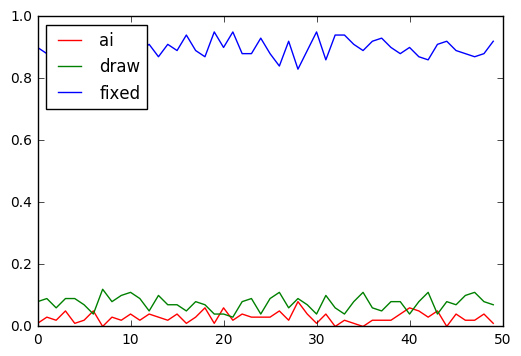

In [13]:
plt.plot(trainedPlayer.stats[:,0],'r',label = 'ai')
plt.plot(trainedPlayer.stats[:,1],'g',label = 'draw')
plt.plot(trainedPlayer.stats[:,2],'b',label = 'fixed')
plt.legend(loc = 'upper left')
plt.show()

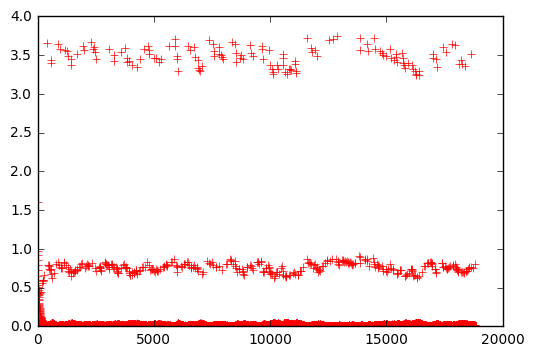

In [14]:
plt.plot(ai.learningNet.cvError,'r+',label = 'train')
plt.show()

In [ ]:
ai.symbol = "O"

In [ ]:
game1 = tictactoeGame(player1=manualPlayer(symbol="X"),player2=ai)

In [ ]:
game1.playGame()

In [ ]:
ai.learningNet.layers[0].weights